In [1]:
"""
Variational autoencoder (VAE) for a 1D normal distribution based on
    https://jmetzen.github.io/2015-11-27/vae.html
Original paper:
    Auto-encoding variational Bayes.
    https://arxiv.org/abs/1312.6114
"""
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

seed=0

In [2]:
class DataDistribution2d(object):
    def __init__(self, mu=([2,6]), sigma=([[.25, 1], [.5,.25]])):
        self.mu    = np.array(mu)
        self.sigma = np.array(sigma)

    def change(self, **kwargs):
      self.mu=np.array(kwargs.get('mu'))
      self.sigma=np.array(kwargs.get('sigma'))

    def sample(self, size): #bu dağılımdan 'size' tane örnek üret
        x = np.random.multivariate_normal(self.mu, self.sigma, size)
        return x

In [3]:
def weight(shape): #shape=nöron sayısı
    bound = np.sqrt(6.0 / np.sum(shape))
    init  = tf.random_uniform_initializer(-bound, bound) #ağırlıkların başlangıç değerleri rastgele uniform dağılımdan, init=tf.random_normal_initializer(stddev=1.0) for gaussian
    return tf.get_variable('W', shape, initializer=init)

def bias(shape):
    init = tf.constant_initializer(0.0) #biasın başlangıç değeri 0
    return tf.get_variable('b', shape, initializer=init)

def linear(name, x, dim): #dim=shape
    with tf.variable_scope(name):
        W = weight([x.get_shape()[-1].value, dim])
        b = bias([dim])
    return tf.matmul(x, W) + b

In [4]:
def encoder(x, hidden_dim=4):
    with tf.name_scope('encoder'):
        x = linear('E_hidden_1', x, hidden_dim)
        x = tf.nn.softmax(x)
        x = linear('E_hidden_2', x, hidden_dim)
        x = tf.nn.softmax(x)
        z_mean    = linear('mean', x, latent_dim) # mean 2 nöronlu bir layer
        z_log_var = linear('log_var', x, latent_dim) #log_var 2 nöronlu bir layer

    return z_mean, z_log_var

def decoder2d(x, hidden_dim=4):
    with tf.name_scope('decoder'):
        x = linear('D_hidden_1', x, hidden_dim)
        x = tf.nn.softplus(x)
        x = linear('D_hidden_2', x, hidden_dim)
        x = tf.nn.softplus(x)
        x = linear('reconstruction', x, 2) # code'u 2D dataya dönüştür

    return x

In [5]:
def encode(x_):
    return sess.run(z_mean, {x: x_})

def generate(z_):
    return sess.run(reconstruction, {z: z_})

def reconstruct(x_):
    return sess.run(reconstruction, {x: x_})

In [6]:
# Compare data and VAE distributions
def plot_distributions_2d(data, reconstructed, epoch, title):     
    # Data
    x_data = data # sample'lar geliyor (dist. değil)

    # Generated samples
    x_vae = reconstructed

    # Plot distributions
    plt.scatter(x_data[:,0], x_data[:,1], c='blue', alpha=0.3, label='Data distribution')

    plt.scatter(x_vae[:,0], x_vae[:,1],  c='red', alpha=0.3, label='Reconstructed distribution')

    # Set limits
    plt.xlim(-2, 10)
    plt.ylim(-2, 10)

    # Legend
    plt.legend(loc='upper right')

    # Axis labels
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(title)

    # Save figure
    plt.savefig('bivariate_normal_vae_'+str(epoch)+'.png')
    plt.close()

In [7]:
# Seed the TF random number generator for reproducible initialization
tf.set_random_seed(seed)

# Seed the random number generator for reproducible batches
np.random.seed(seed)

# Hyperparameters
learning_rate = 0.002 # 2.5*1e-5
num_steps     = 20000 #10000
batch_size    = 100
num_examples  = 5000 #20000
check_every   = 1000


In [8]:
# 2-D vae

# For feeding in data
x = tf.placeholder(tf.float32, [None, 2])

# Latent space dimension
latent_dim = 1 #2d dist yüksek dim. önemli değil

# Model
z_mean, z_log_var = encoder(x)
epsilon = tf.random_normal(tf.shape(z_log_var))
z = z_mean + epsilon * tf.exp(0.5*z_log_var) # "Reparametrization trick"
logits = decoder2d(z) #decoder2d for 2d dist
reconstruction = logits #tf.nn.sigmoid(logits)

# Reconstruction loss
CE = tf.square(logits - x)
# Sum over all dimensions for sum_ce
CE = tf.reduce_sum(CE, 1) # tf.reduce_sum(CE, [0, 1])

# Latent loss
KL = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
KL = -1 * tf.reduce_sum(KL, 1)

# Total loss
loss = tf.reduce_mean(CE + KL)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train_op  = optimizer.minimize(loss)

# Print list of variables
print("")
print("Variables")
print("---------")
variables  = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
num_params = 0
for v in variables:
    num_params += np.prod(v.get_shape().as_list())
    print(v.name, v.get_shape())
print("=> Total number of parameters =", num_params)

# TF session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Data distribution
data = DataDistribution2d()
#data.change(mu=([6, 9]), sigma =([[.25, 1], [.5,.25]]))
data2 = DataDistribution2d()
data2.change(mu=([6, 2]), sigma =([[.25, 1], [.5,.25]]))
#data3 = DataDistribution2d()
#data3.change(mu=([7, 7]), sigma =([[.1, .001], [.001, .01]]))
#data4 = DataDistribution2d()
#data4.change(mu=([1, 1]), sigma =([[1, -1], [1, -1]])) # mu=([6,2])
#data2=None
data3=None
data4=None

#num_batches_per_epoch = num_examples // batch_size
data_samples=data.sample(num_examples)
test_data=data_samples

if(data2):
  data2_samples=data2.sample(num_examples)
  test_data = np.concatenate((test_data, data2_samples), axis=0)
if(data3):
  data3_samples=data3.sample(num_examples)
  test_data = np.concatenate((test_data, data3_samples), axis=0)
if(data4):
  data4_samples=data4.sample(num_examples)
  test_data = np.concatenate((test_data, data4_samples), axis=0)    
    

# Minimize the loss function
for step in range(num_steps):
    batch_x   = data.sample(batch_size)
    if(data2):
      batch_x2   = data2.sample(batch_size)
      batch_x   = np.concatenate((batch_x, batch_x2), axis=0)
    if(data3):
      batch_x3   = data3.sample(batch_size)
      batch_x   = np.concatenate((batch_x, batch_x3), axis=0)    
    if(data4):
      batch_x4   = data4.sample(batch_size)
      batch_x   = np.concatenate((batch_x, batch_x4), axis=0)
    feed_dict = {x: batch_x} # reshape vector haline getirmek için
    _, current_loss = sess.run([train_op, loss], feed_dict)

    if (step+1) % check_every == 0:
        title="After " + str(step+1) + " steps, loss = " + str(round(current_loss, 4))
        reconstructed = reconstruct(test_data)
        plot_distributions_2d(test_data, reconstructed, int((step+1)/check_every), title) # 2 dist için data2_samples da ver


Variables
---------
E_hidden_1/W:0 (2, 4)
E_hidden_1/b:0 (4,)
E_hidden_2/W:0 (4, 4)
E_hidden_2/b:0 (4,)
mean/W:0 (4, 1)
mean/b:0 (1,)
log_var/W:0 (4, 1)
log_var/b:0 (1,)
D_hidden_1/W:0 (1, 4)
D_hidden_1/b:0 (4,)
D_hidden_2/W:0 (4, 4)
D_hidden_2/b:0 (4,)
reconstruction/W:0 (4, 2)
reconstruction/b:0 (2,)
=> Total number of parameters = 80


C:\Users\Melike Nur Mermer\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
pap=8

In [10]:
-1. -pap

-9.0

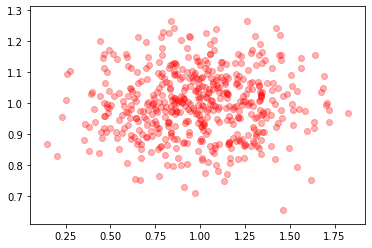

In [11]:
data4 = DataDistribution2d()
data4.change(mu=([1, 1]), sigma =([[.1, .001], [.001, .01]])) # mu=([6,2])

x_vae=data4.sample(500)
plt.scatter(x_vae[:,0], x_vae[:,1],  c='red', alpha=0.3, label='Reconstructed distribution')